Last updated on Apr 9, 2020

# Demo script for the analyses done in Nakamura and Huang (2018, Science)

This is a complimentary demo script that can be used to implement the local wave activity, fluxes and flux convergence/divergence computation required in the analyses presented in Nakamura and Huang, Atmospheric Blocking as a Traffic Jam in the Jet Stream. Science. (2018)

This notebook demonstrate how to compute local wave activity and all the flux terms in equations (2) and (3) in NH2018 with the updated functionality in the python package `hn2016_falwa`. To run the script, please install the 
package `hn2016_falwa` using
```
python setup.py develop
```
after cloning the [GitHub repo](http://github.com/csyhuang/hn2016_falwa).

The functionalities are enhanced and included in the class object `QGField` under `hn2016_falwa.oopinterface`. Please refer to the [documentation](http://hn2016-falwa.readthedocs.io/) (search `QGField`) or the end of this notebook for the input/methods this class provides.

Please [raise an issue in the GitHub repo](https://github.com/csyhuang/hn2016_falwa/issues) or contact Clare S. Y. Huang (csyhuang@uchicago.edu) if you have any questions or suggestions regarding the package.

In [1]:
import numpy as np
from numpy import dtype
from math import pi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
from hn2016_falwa.oopinterface import QGField
import hn2016_falwa.utilities as utilities
import datetime as dt

# Load ERA-Interim reanalysis data retrieved from ECMWF server
The sample script in this directory `download_example.py` include the code to retrieve zonal wind field U, meridional
wind field V and temperature field T at various pressure levels. Given that you have an account on ECMWF server and
have the `ecmwfapi` package installed, you can run the scripts to download data from there:
```
python download_example.py
```

In [2]:
# --- Load the zonal wind and QGPV at 240hPa --- #
u_file = Dataset('2005-01-23_to_2005-01-30_u.nc', mode='r')
v_file = Dataset('2005-01-23_to_2005-01-30_v.nc', mode='r')
t_file = Dataset('2005-01-23_to_2005-01-30_t.nc', mode='r')

time_array = u_file.variables['time'][:]
time_units = u_file.variables['time'].units
time_calendar = u_file.variables['time'].calendar
ntimes = time_array.shape[0]

print('Dimension of time: {}'.format(time_array.size))

Dimension of time: 32


# Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [3]:
xlon = u_file.variables['longitude'][:]

# latitude has to be in ascending order
ylat = u_file.variables['latitude'][:]
if np.diff(ylat)[0]<0:
    print('Flip ylat.')
    ylat = ylat[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.variables['level'][:]
if np.diff(plev)[0]>0:
    print('Flip plev.')    
    plev = plev[::-1]

nlon = xlon.size
nlat = ylat.size
nlev = plev.size

Flip ylat.
Flip plev.


In [4]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
dz = 1000.                          # differential height element
height = np.arange(0,kmax)*dz       # pseudoheight [m]
dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                #just above the ground (z=1km) to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.

# Create a netCDF file to store output

A netCDF file `2005-01-23_to_2005-01-30_output.nc` with same number of time steps in the input file is created to store all the computed quantities.

In [5]:
# === Outputing files ===
output_fname = '2005-01-23_to_2005-01-30_output.nc'
output_file = Dataset(output_fname, 'w')
output_file.createDimension('levelist',kmax)
output_file.createDimension('latitude',nlat)
output_file.createDimension('longitude',nlon)
output_file.createDimension('time',ntimes) 
plevs = output_file.createVariable('levelist',dtype('float32').char,('levelist',)) # Define the coordinate variables
lats = output_file.createVariable('latitude',dtype('float32').char,('latitude',)) # Define the coordinate variables
lons = output_file.createVariable('longitude',dtype('float32').char,('longitude',))
times = output_file.createVariable('time',dtype('int').char,('time',))    
plevs.units = 'hPa' 
lats.units = 'degrees_north'
lons.units = 'degrees_east'
times.units = time_units
times.calendar = time_calendar
plevs[:] = p0 * np.exp(-height/hh)
lats[:]  = ylat 
lons[:]  = xlon
times[:] = time_array
qgpv = output_file.createVariable('qgpv',dtype('float32').char,('time','levelist','latitude','longitude'))
qgpv.units = '1/s' 
interpolated_u = output_file.createVariable('interpolated_u',dtype('float32').char,('time','levelist','latitude','longitude'))
interpolated_u.units = 'm/s' 
interpolated_v = output_file.createVariable('interpolated_v',dtype('float32').char,('time','levelist','latitude','longitude'))
interpolated_v.units = 'm/s'
interpolated_theta = output_file.createVariable('interpolated_theta',dtype('float32').char,('time','levelist','latitude','longitude'))
interpolated_theta.units = 'K' 
qref = output_file.createVariable('qref',dtype('float32').char,('time','levelist','latitude'))
qref.units = '1/s' 
uref = output_file.createVariable('uref',dtype('float32').char,('time','levelist','latitude'))
uref.units = 'm/s' 
ptref = output_file.createVariable('ptref',dtype('float32').char,('time','levelist','latitude'))
ptref.units = 'K' 
lwa = output_file.createVariable('lwa',dtype('float32').char,('time','levelist','latitude','longitude'))
lwa.units = 'm/s'
adv_flux_f1 = output_file.createVariable('Zonal advective flux F1',dtype('float32').char,('time','latitude','longitude'))
adv_flux_f1.units = 'm**2/s**2'    
adv_flux_f2 = output_file.createVariable('Zonal advective flux F2',dtype('float32').char,('time','latitude','longitude'))
adv_flux_f2.units = 'm**2/s**2'  
adv_flux_f3 = output_file.createVariable('Zonal advective flux F3',dtype('float32').char,('time','latitude','longitude'))
adv_flux_f3.units = 'm**2/s**2'  
adv_flux_conv = output_file.createVariable('Zonal advective flux Convergence -Div(F1+F2+F3)',dtype('float32').char,('time','latitude','longitude'))
adv_flux_conv.units = 'm/s**2'  
divergence_eddy_momentum_flux = output_file.createVariable('Eddy Momentum Flux Divergence',dtype('float32').char,('time','latitude','longitude'))
divergence_eddy_momentum_flux.units = 'm/s**2'  
meridional_heat_flux = output_file.createVariable('Low-level Meridional Heat Flux',dtype('float32').char,('time','latitude','longitude'))
meridional_heat_flux.units = 'm/s**2' 
lwa_baro = output_file.createVariable('lwa_baro',dtype('float32').char,('time','latitude','longitude'))
lwa_baro.units = 'm/s' 
u_baro = output_file.createVariable('u_baro',dtype('float32').char,('time','latitude','longitude'))
u_baro.units = 'm/s' 

# Set the level of pressure and the timestamp to display below

In [6]:
tstamp = [dt.datetime(2005,1,23,0,0) + dt.timedelta(seconds=6*3600) * tt for tt in range(ntimes)]
plev_selected = 10 # selected pressure level to display
tstep_selected = 0

# Set names of the variables to display

# Loop through the input file and store all the computed quantities in a netCDF file

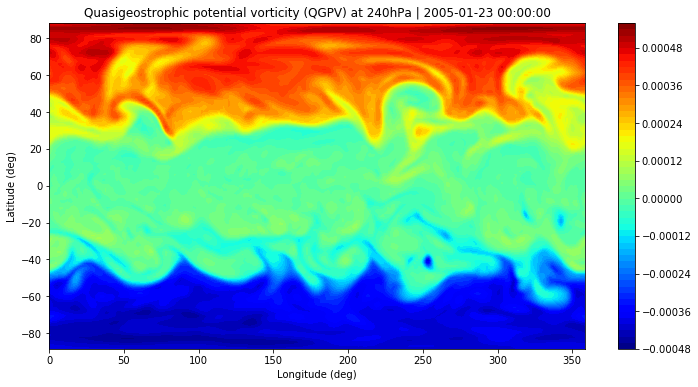

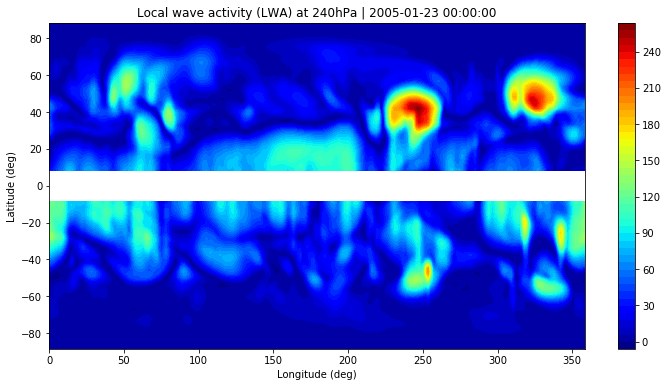

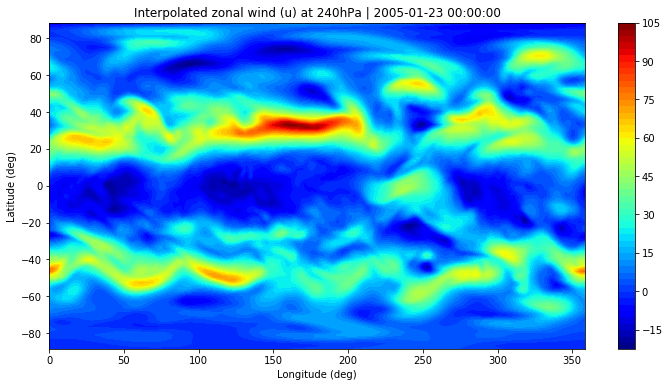

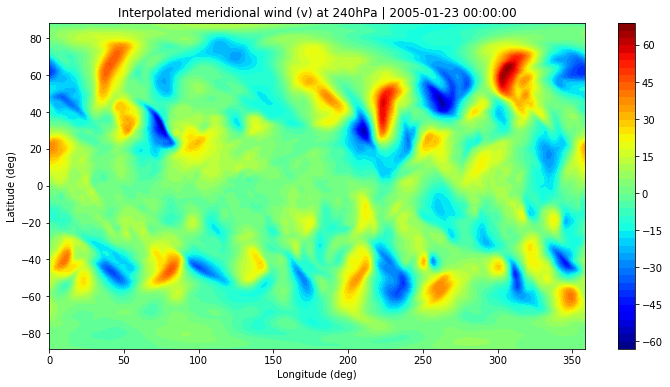

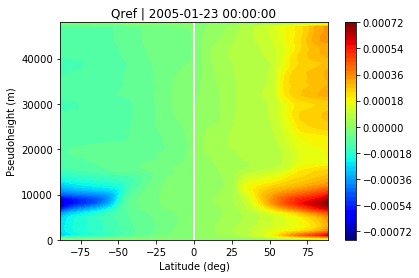

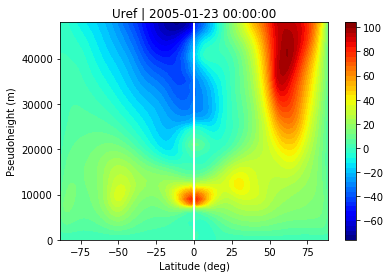

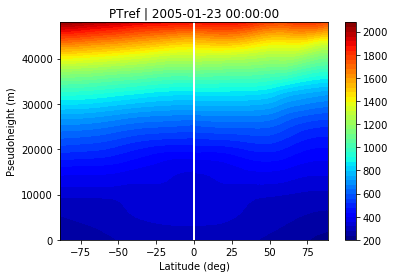

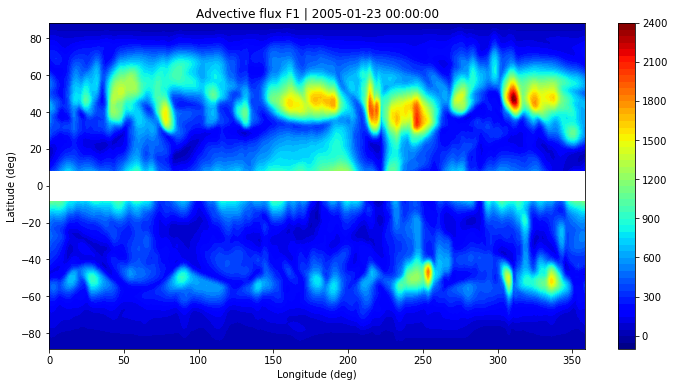

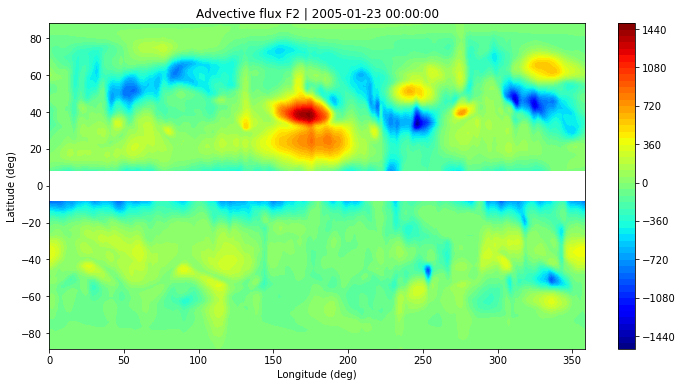

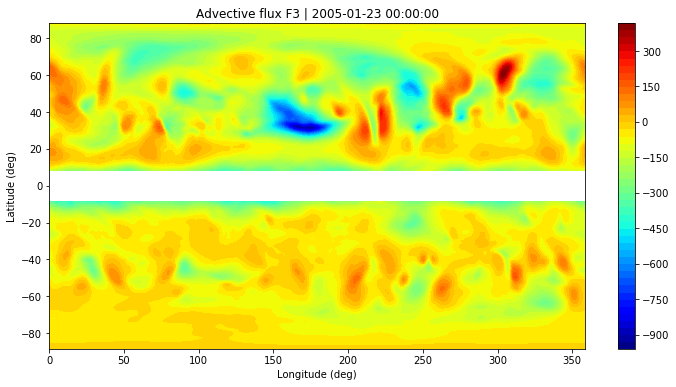

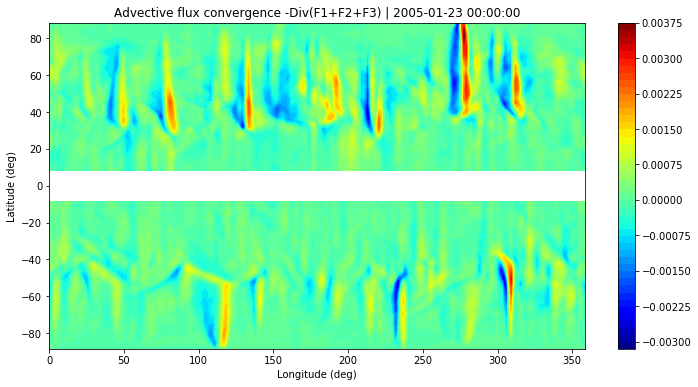

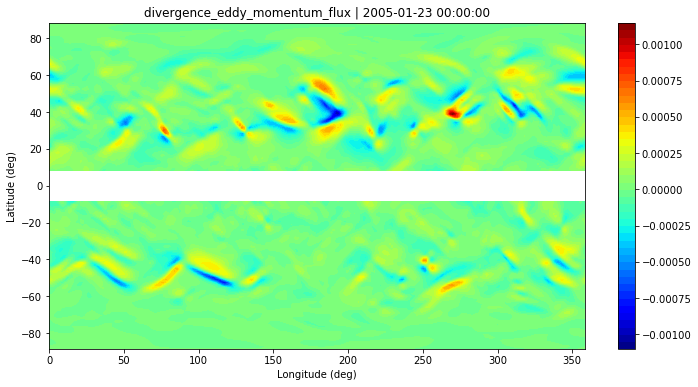

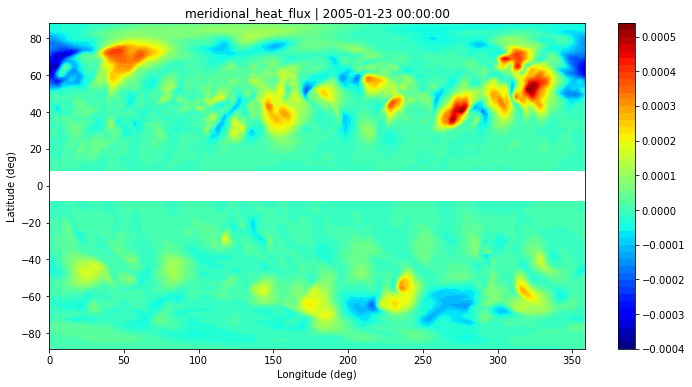

tstep = 0/32

tstep = 1/32

tstep = 2/32

tstep = 3/32

tstep = 4/32

tstep = 5/32

tstep = 6/32

tstep = 7/32

tstep = 8/32

tstep = 9/32

tstep = 10/32

tstep = 11/32

tstep = 12/32

tstep = 13/32

tstep = 14/32

tstep = 15/32

tstep = 16/32

tstep = 17/32

tstep = 18/32

tstep = 19/32

tstep = 20/32

tstep = 21/32

tstep = 22/32

tstep = 23/32

tstep = 24/32

tstep = 25/32

tstep = 26/32

tstep = 27/32

tstep = 28/32

tstep = 29/32

tstep = 30/32

tstep = 31/32

Output 32 timesteps of data to the file 2005-01-23_to_2005-01-30_output.nc


In [7]:
for tstep in range(32):  # or ntimes
    
    uu = u_file.variables['u'][tstep, ::-1, ::-1, :].data
    vv = v_file.variables['v'][tstep, ::-1, ::-1, :].data
    tt = t_file.variables['t'][tstep, ::-1, ::-1, :].data

    qgfield_object = QGField(xlon, ylat, plev, uu, vv, tt)

    qgpv[tstep, :, :, :], interpolated_u[tstep, :, :, :], interpolated_v[tstep, :, :, :], \
        interpolated_theta[tstep, :, :, :], static_stability = qgfield_object.interpolate_fields()

    qref[tstep, :, :], uref[tstep, :, :], ptref[tstep, :, :] = \
        qgfield_object.compute_reference_states(northern_hemisphere_results_only=False)

    adv_flux_f1[tstep, :, :], \
    adv_flux_f2[tstep, :, :], \
    adv_flux_f3[tstep, :, :], \
    adv_flux_conv[tstep, :, :], \
    divergence_eddy_momentum_flux[tstep, :, :], \
    meridional_heat_flux[tstep, :, :], \
    lwa_baro[tstep, :, :], \
    u_baro[tstep, :, :], \
    lwa[tstep, :, :, :] \
        = qgfield_object.compute_lwa_and_barotropic_fluxes(northern_hemisphere_results_only=False)

    if tstep == tstep_selected:
        # === Below demonstrate another way to access the computed variables ===
        # 3D Variables that I would choose one pressure level to display
        variables_3d = [
            (qgfield_object.qgpv, 'Quasigeostrophic potential vorticity (QGPV)'),
            (qgfield_object.lwa, 'Local wave activity (LWA)'),
            (qgfield_object.interpolated_u, 'Interpolated zonal wind (u)'),
            (qgfield_object.interpolated_v, 'Interpolated meridional wind (v)')]

        # Reference states to be displayed on y-z plane
        variables_yz = [
            (qgfield_object.qref, 'Qref'),
            (qgfield_object.uref, 'Uref'),
            (qgfield_object.ptref, 'PTref')]

        # Vertically averaged variables to be displayed on x-y plane
        variables_xy = [
            (qgfield_object.adv_flux_f1, 'Advective flux F1'),
            (qgfield_object.adv_flux_f2, 'Advective flux F2'),
            (qgfield_object.adv_flux_f3, 'Advective flux F3'),
            (qgfield_object.convergence_zonal_advective_flux, 'Advective flux convergence -Div(F1+F2+F3)'),
            (qgfield_object.divergence_eddy_momentum_flux, 'divergence_eddy_momentum_flux'),
            (qgfield_object.meridional_heat_flux, 'meridional_heat_flux')
        ]
        
        # Plot 240 hPa of 3D-variables
        for variable, name in variables_3d:
            plt.figure(figsize=(12,6))
            plt.contourf(xlon, ylat[1:-1], variable[plev_selected, 1:-1, :], 50, cmap='jet')
            if name=='Local wave activity (LWA)':
                plt.axhline(y=0, c='w', lw=30)
            plt.colorbar()
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Longitude (deg)')
            plt.title(name + ' at 240hPa | ' + str(tstamp[tstep]))
            plt.show()
        
        # Plot reference states
        for variable, name in variables_yz:
            plt.figure(figsize=(6,4))
            plt.contourf(ylat[1:-1], height, variable[:, 1:-1], 50, cmap='jet')
            plt.axvline(x=0, c='w', lw=2)
            plt.xlabel('Latitude (deg)')
            plt.ylabel('Pseudoheight (m)')
            plt.colorbar()
            plt.title(name + ' | ' + str(tstamp[tstep]))
            plt.show()

        # Plot barotropic (2D-)variables
        for variable, name in variables_xy:
            plt.figure(figsize=(12,6))
            plt.contourf(xlon, ylat[1:-1], variable[1:-1, :], 50, cmap='jet')
            plt.axhline(y=0, c='w', lw=30)
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Longitude (deg)')
            plt.colorbar()
            plt.title(name + ' | ' + str(tstamp[tstep]))
            plt.show()

    print('tstep = {}/{}\n'.format(tstep, ntimes))
    
output_file.close()
print('Output {} timesteps of data to the file {}'.format(tstep + 1, output_fname))